In [31]:
from pyDecision.algorithm import ahp_method
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

In [32]:
df = pd.read_csv("results/filtered_responses.csv")

In [33]:
def AHP(matrix,derivation="geometric"):
    #weights
    weights,rc = ahp_method(matrix,wd=derivation)

    for i in range (0, weights.shape[0]):
        print ('w_w(feature '+str(i+1)+'): ',round(weights[i],3))

    #consistency ratio
    print('RC: ' + str(round(rc, 2)))
    if (rc > 0.1):
        print('The solution is inconsistent, pairwise comparison must be reviewed')
    else:
        print('The solution is consistent')

    return weights

In [34]:
# decision matrix 
modal_decision_worker = [[1,3,9,6],[0.33,1,8,3],[0.11,0.12,1,0.2],[0.17,0.33,5,1]]
modal_decision_green = [[1,0.33,0.11,3],[3,1,0.17,5],[9,6,1,9],[0.33,0.2,0.11,1]]
modal_decision_safe = [[1,2,6,6],[0.50,1,6,5],[0.17,0.17,1,0.50],[0.17,0.20,2,1]]
modal_decision_tourist = [[1,0.50,0.50,0.17],[2,1,3,1],[2,0.33,1,0.20],[6,1,5,1]]

In [35]:
print('Worker')
weights_w = AHP(modal_decision_worker)
print('\nGreen')
weights_g = AHP(modal_decision_green)
print('\nSafe')
weights_s = AHP(modal_decision_safe)
print('\nTourist')
weights_t = AHP(modal_decision_tourist)

Worker
w_w(feature 1):  0.575
w_w(feature 2):  0.271
w_w(feature 3):  0.037
w_w(feature 4):  0.117
RC: 0.07
The solution is consistent

Green
w_w(feature 1):  0.084
w_w(feature 2):  0.185
w_w(feature 3):  0.688
w_w(feature 4):  0.043
RC: 0.08
The solution is consistent

Safe
w_w(feature 1):  0.508
w_w(feature 2):  0.343
w_w(feature 3):  0.06
w_w(feature 4):  0.089
RC: 0.04
The solution is consistent

Tourist
w_w(feature 1):  0.091
w_w(feature 2):  0.315
w_w(feature 3):  0.121
w_w(feature 4):  0.472
RC: 0.07
The solution is consistent


In [36]:
def evaluate_routes(routes, weights_w, columns):
    routes_parameters = routes[columns[1:]]
    results_array = []
    result = 0
    for route in routes_parameters.iterrows(): # iterrows !!!
        result = np.multiply(np.array(route[1]), np.array(weights_w))
        results_array.append(np.sum(result))
    return results_array

def evaluate_all(weight_list,dataframe_list,columns):
    result = []
    for i in weight_list:
        result.append([])
    
    for w in range(len(weight_list)):
        for df in dataframe_list:
            result[w].append(evaluate_routes(df,weight_list[w],columns))
    return result

def Id_SetId(result_list,dataframe_list):
    id_list = []
    for i in result_list:
        id_list.append([])
    
    for result in range(len(result_list)):
        #for weight in result_list[result]:
        for weight in range(len(result_list[result])):
            
            max_value = max(result_list[result][weight])
            max_index = result_list[result][weight].index(max_value)
            df = dataframe_list[weight].loc[max_index]
            id_list[result].append([max_value,df['index'],df['setID']])
    return id_list

In [37]:
dfs = []
for i in range(int(df['setID'].max())): # df.['setID'].unique()
    x = df.loc[df['setID'] == i]
    if x.empty or x.isnull().values.any():
        continue
    x = x.reset_index()
    dfs.append(x)
print("Numbers of OD 2 pairs:",len(dfs))

Numbers of OD 2 pairs: 136


In [38]:
columns = ['index','duration_norm', 'distance_norm', 'emission_norm', 'price_norm']

weight_list = [weights_w,weights_g,weights_s,weights_t]
r = evaluate_all(weight_list,dfs,columns)
id_list = Id_SetId(r,dfs)

In [39]:
def sum_all(id_list,dataframe_list,columns):
    
    means = []
    
    for i in range(len(id_list)):
        
        mean_df = pd.DataFrame(columns=columns)
        
        for j in range(len(dataframe_list)):
            #x = dfs[0].loc[dfs[0]['ID'] == id_list[0][0][1]]
            mean_df = pd.concat([mean_df,dataframe_list[j].loc[dataframe_list[j]['index'] == id_list[i][j][1]]],join='inner')
        means.append(mean_df.mean())
        
    return means

def sum_greedy(dataframe_list,columns,norms):
    
    greedy_means = []
    
    for i in norms:
        
        mean_df = pd.DataFrame(columns=columns)
        
        for j in range(len(dataframe_list)):
            
            mean_df = pd.concat([mean_df, dataframe_list[j].loc[dataframe_list[j][i] == 1]],join='inner')
            
        greedy_means.append(mean_df.mean())
    
    return greedy_means

In [40]:
#columns = ["crimeNorm","accidentNorm","natureNorm","attractionNorm","durationNorm","trafficNorm","lengthNorm","crimes",
#           "accidents","attractions","nature","traffic","duration","length","polution","polutionNorm"]

#norms = ["crimeNorm","accidentNorm","natureNorm","attractionNorm","durationNorm","trafficNorm","lengthNorm","polutionNorm"]

columns = ["duration","distance","emission","price","duration_norm","distance_norm","emission_norm","price_norm"]

norms = ["duration_norm","distance_norm","emission_norm","price_norm"]

mean = sum_all(id_list,dfs,columns)
greedy_means = sum_greedy(dfs,columns,norms)

In [43]:
def PDFKS(dataframe_list,best_list,sum_name):
    
    best_list_values = []
    for i in range(len(sum_name)):
        best_list_values.append(best_list[i][sum_name[i]])

    result = []
    for i in range(len(dataframe_list)):
        
        line = []
        
        for j in range(len(sum_name)): # iterate over alternatives

            df_value = dataframe_list[i][sum_name[j]]

            best_value = best_list_values[j]
            if best_value == 0:
                div = 1
            else:
                div = best_value * 100
            line.append((df_value-best_value)/div)
            
        result.append(line)
    return result

In [44]:
#sum_name = ['crimes','accidents','nature','attractions','duration','traffic','length','polution']

sum_name = ["duration","distance","emission","price"]

result = PDFKS(mean+greedy_means,greedy_means,sum_name)

# PDFKS Heat Map Plot & Histogram

In [45]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

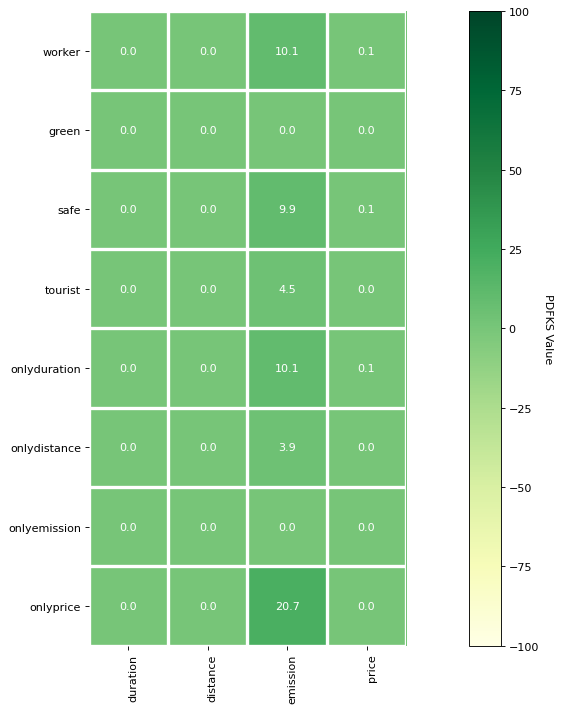

In [46]:
#profiles = ['worker','green','safe','tourist','onlyCrimes','onlyAccidents','onlyNature','onlyAttractions',
#            'onlyDuration','onlyTraffic','onlyLength','onlyPolution']

#features = ['crimes','accidents','nature','attractions','duration','traffic','length','polution']

profiles = ["worker","green","safe","tourist","onlyduration","onlydistance","onlyemission","onlyprice"]

features = ["duration","distance","emission","price"]

result_np = np.array(result)

fig, ax = plt.subplots(figsize=(16,9),dpi=80)

im, cbar = heatmap(result_np, profiles, features, ax=ax,
                   cmap="YlGn", cbarlabel="PDFKS Value",vmin=-100, vmax=100)
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

In [47]:
result_sum = []
for i in result:
    res = 0
    for j in i:
        res += abs(j)
    result_sum.append(res)
    
x = list(zip(profiles,result_sum))

sorted_result = sorted(x,key=lambda x: int(x[1]))

profiles_names = []
values = []
for (i,j) in sorted_result:
    profiles_names.append(i)
    values.append(j)

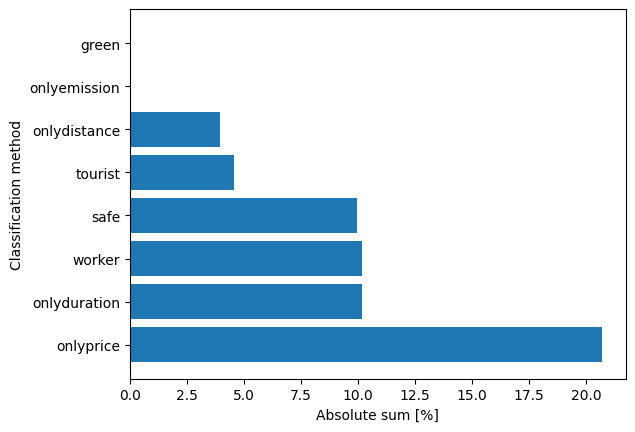

In [48]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(profiles_names, values, align='center')
ax.set_yticks(profiles_names, labels=profiles_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Absolute sum [%]')
ax.set_ylabel('Classification method')

plt.show()

In [49]:
#features = ['crimes','accidents','nature','attractions','duration','traffic','length','polution']
#profile = ['Worker', 'Green', 'Safe', 'Tourist']
#best_values = [507757.105634,126.691275,809605.474893,4.756345,1967.288732,0.826151,15745.302817,28.212792]

#criminality
"""
fig, ax = plt.subplots()

profile = ['Worker', 'Green', 'Safe', 'Tourist']
value = [585863.605634, 592358.915493, 526048.500000, 651023.119718]

ax.bar(profile, value)

ax.axhline(y = 507757.105634, color = 'r', linestyle = '--', label = "Best Value")
ax.set_ylabel('Crime occurance')
ax.set_title('Average Crime occurance for each profile')

plt.show()
"""

'\nfig, ax = plt.subplots()\n\nprofile = [\'Worker\', \'Green\', \'Safe\', \'Tourist\']\nvalue = [585863.605634, 592358.915493, 526048.500000, 651023.119718]\n\nax.bar(profile, value)\n\nax.axhline(y = 507757.105634, color = \'r\', linestyle = \'--\', label = "Best Value")\nax.set_ylabel(\'Crime occurance\')\nax.set_title(\'Average Crime occurance for each profile\')\n\nplt.show()\n'